In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE

# Model selection and evaluation
from sklearn.model_selection import cross_val_predict, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_recall_curve, make_scorer, ConfusionMatrixDisplay

# Resampling techniques
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Classifiers
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

# SHapley Additive exPlanations
import shap

# Step1: Load DataSet

In [2]:
# Read the Data Set
path = 'df_faults_even.xlsx'
DF_faulty = pd.read_excel(path, index_col=0) # With New Features

In [3]:
# Data Preparation
df_trial = DF_faulty.copy()
X_full = df_trial.drop(columns=['Datetime', 'Fault'])
y_full = df_trial["Fault"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

# Training sets
train_df = X_train.copy()
train_df['Fault'] = y_train

# Testing set
test_df = X_test.copy()
test_df['Fault'] = y_test

# Shape
print(f"Training DataFrame shape: {train_df.shape}")
print(f"Testing DataFrame shape: {test_df.shape}")

# Class distribution of training dataset
class_distribution = train_df['Fault'].value_counts()
print("Class distribution in the training set:")
print(class_distribution)

# Class distribution of testing dataset
class_distribution_test = test_df['Fault'].value_counts()
print("Class distribution in the testing set:")
print(class_distribution_test)

Training DataFrame shape: (56062, 114)
Testing DataFrame shape: (14016, 114)
Class distribution in the training set:
Fault
BPS      7008
CHS      7008
CTF      7008
BPL      7008
CTS      7008
CPP      7008
N        7007
CTPID    7007
Name: count, dtype: int64
Class distribution in the testing set:
Fault
CTF      1752
CTS      1752
CTPID    1752
N        1752
CHS      1752
BPL      1752
CPP      1752
BPS      1752
Name: count, dtype: int64


### Prepare Training and Testing Dataset

In [4]:
# Prepare Data (Training and Testing)
df_train = train_df.copy()
df_test = test_df.copy()

# Features
X_train = df_train.drop(columns=['Fault'])
X_test = df_test.drop(columns=['Fault'])

# Label Encoding
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(df_train['Fault'])
y_test_encoded = encoder.transform(df_test['Fault'])

# Define the target faults for binary classification (BPX vs Rest)
target_faults = encoder.transform(["BPL", "BPS"])  # 1:BPX, 0:Rest
y_train_binary = np.where(np.isin(y_train_encoded, target_faults), 1, 0)
y_test_binary = np.where(np.isin(y_test_encoded, target_faults), 1, 0)

# Step2: Training Phase

# Algorithm Selection

In [ ]:
# Define models
models = {
    "GB": GradientBoostingClassifier(random_state=42),
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGB": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
}

# Stratified 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # CV F1 scores (positive class)
    cv_f1_scores = cross_val_score(pipeline,X_train,y_train_binary,cv=cv,scoring='f1', n_jobs=-1)
    
    print(f"{model_name}: Mean F1 Score = {np.mean(cv_f1_scores):.4f}")

GB: Mean F1 Score = 0.9703
DT: Mean F1 Score = 0.9634
RF: Mean F1 Score = 0.9747
XGB: Mean F1 Score = 0.9774
LightGBM: Mean F1 Score = 0.9767
CatBoost: Mean F1 Score = 0.9767


# Feature Selection

### Feature Importances with Cross-Validation

In [5]:
# Stratified 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

feature_importances = []
for train_idx, val_idx in cv.split(X_train, y_train_binary):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train_binary[train_idx], y_train_binary[val_idx]
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(random_state=42, n_jobs=-1))
    ])
    pipeline.fit(X_cv_train, y_cv_train)

    feature_importances.append(pipeline.named_steps['classifier'].feature_importances_) # Aggregate the Feature Importances

# Average of Feature Importances
mean_importances = np.mean(feature_importances, axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                Feature  Importance
106          CDWL_Error    0.527041
107      CDWL_DeltaFLOW    0.073802
69             TWV_CTRL    0.066769
1         CDWL_PM_POW_1    0.057888
66      CWL_SEC_SW_TEMP    0.052392
..                  ...         ...
23      CHL_SWCD_TEMP_3    0.000000
25        CHL_SW_TEMP_2    0.000000
26        CHL_SW_TEMP_3    0.000000
55   CWL_PRI_SW_TEMPSPT    0.000000
0          CDWL_CW_FLOW    0.000000

[113 rows x 2 columns]


### Visuazliation of Feature Importances

['CDWL_Error', 'CDWL_DeltaFLOW', 'TWV_CTRL', 'CDWL_PM_POW_1', 'CWL_SEC_SW_TEMP', 'CWL_PRI_SW_TEMP', 'CHL_RW_TEMP_1', 'CDWL_DeltaTEMP', 'CT_FLOW_1', 'CHL_SWCD_TEMP_1', 'CHL_RWCD_TEMP_1', 'CT_TotalFLOW', 'CDWL_SW_TEMP', 'CHL_SW_TEMP_1', 'CWL_SEC_PM_POW_2', 'CWL_SEC_RW_TEMP', 'CT_SW_TEMP_1', 'CWL_SEC_PM_SPD_1', 'CDWL_RW_TEMP', 'CWL_SEC_CW_FLOW', 'CHL_COMP_SPD_CTRL_1', 'CWL_SEC_PM_SPD_2', 'OA_TEMP_WB', 'CWL_SEC_DP', 'CWL_SEC_POW', 'PLANT_POW_1', 'CHL_POW_1', 'CWL_SEC_PM_POW_1', 'OA_TEMP', 'CT_RW_TEMP_1']


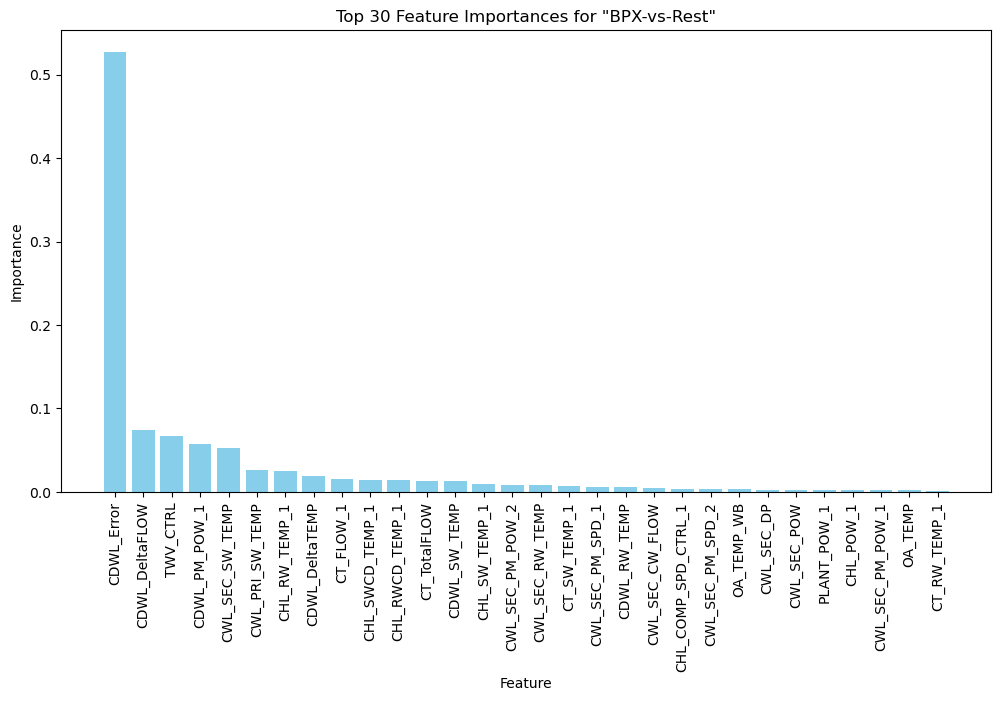

In [ ]:
# Number of features to show
TOP_N = 30
top_features = feature_importance_df.head(TOP_N)['Feature'].tolist()
print(top_features)

# Plot Feature Importances Graph
plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df.head(TOP_N)['Feature'], 
        feature_importance_df.head(TOP_N)['Importance'], 
        color='skyblue')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title(f'Top {TOP_N} Feature Importances for "BPX-vs-Rest"')
plt.xticks(rotation=90)
plt.show()

### Feature Importance Ranking Based Sequential Forward Feature Selection (FIR-SFFS)

In [9]:
# Stratified 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

feature_f1_scores = {}
for n in range(2, 51, 1):  # Change the step size if needed
    X_features = X_train[top_features[:n]]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(random_state=42, n_jobs=-1))
    ])

    # Cross-Validation
    cv_results = cross_val_score(pipeline, X_features, y_train_binary, cv=cv, scoring='f1', n_jobs=-1)

    # Mean of F1 scores
    mean_f1_score = np.mean(cv_results)

    # Store the result
    feature_f1_scores[n] = mean_f1_score
    print(f"Top {n} Features: Mean F1 Score = {mean_f1_score:.4f}")

# Convert results to DataFrame
f1_results_df = pd.DataFrame(list(feature_f1_scores.items()), columns=['Num_Features', 'F1_Score'])

Top 2 Features: Mean F1 Score = 0.9496
Top 3 Features: Mean F1 Score = 0.9507
Top 4 Features: Mean F1 Score = 0.9506
Top 5 Features: Mean F1 Score = 0.9701
Top 6 Features: Mean F1 Score = 0.9708
Top 7 Features: Mean F1 Score = 0.9710
Top 8 Features: Mean F1 Score = 0.9715
Top 9 Features: Mean F1 Score = 0.9716
Top 10 Features: Mean F1 Score = 0.9715
Top 11 Features: Mean F1 Score = 0.9718
Top 12 Features: Mean F1 Score = 0.9710
Top 13 Features: Mean F1 Score = 0.9717
Top 14 Features: Mean F1 Score = 0.9714
Top 15 Features: Mean F1 Score = 0.9738
Top 16 Features: Mean F1 Score = 0.9750
Top 17 Features: Mean F1 Score = 0.9744
Top 18 Features: Mean F1 Score = 0.9758
Top 19 Features: Mean F1 Score = 0.9762
Top 20 Features: Mean F1 Score = 0.9766
Top 21 Features: Mean F1 Score = 0.9767
Top 22 Features: Mean F1 Score = 0.9770
Top 23 Features: Mean F1 Score = 0.9769
Top 24 Features: Mean F1 Score = 0.9770
Top 25 Features: Mean F1 Score = 0.9768
Top 26 Features: Mean F1 Score = 0.9765
Top 27 F

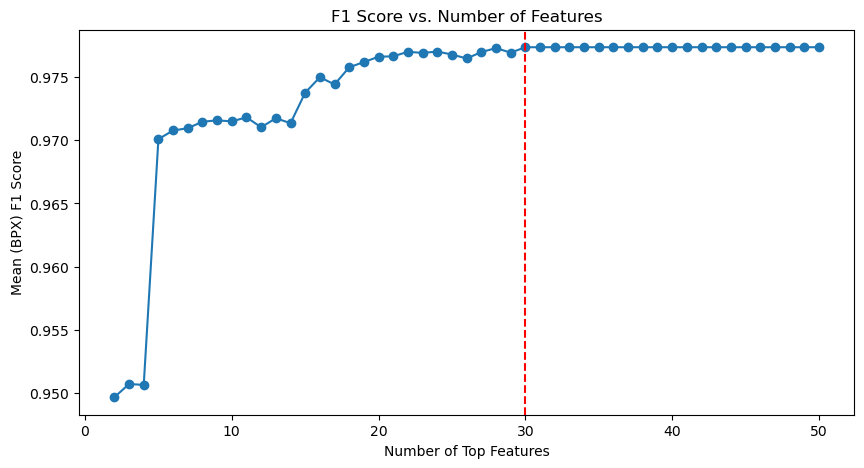

In [11]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(f1_results_df['Num_Features'], f1_results_df['F1_Score'], marker='o', linestyle='-')
plt.xlabel('Number of Top Features')
plt.ylabel('Mean (BPX) F1 Score')
plt.title('F1 Score vs. Number of Features')
plt.axvline(x=30, color='r', linestyle='--') # Peak or Elbow Point
plt.show()

# Hyper-Parameter Searching

In [ ]:
X_train_features = X_train[top_features[:30]]


param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Default: 100
    'classifier__learning_rate': [0.2, 0.3, 0.4],  # Default: 0.3
    'classifier__max_depth': [4, 6, 8],  # Default: 6
    'classifier__gamma': [0, 0.1, 0.2],  # Default: 0
    'classifier__subsample': [0.85, 1.0],  # Default: 1.0
    'classifier__reg_alpha': [0, 0.1, 0.2],  # Default: 0
    'classifier__reg_lambda': [0.8, 1, 1.2],  # Default: 1
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, n_jobs=-1))
])

# GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, scoring='f1', cv=5, verbose=3)
grid_search.fit(X_train_features, y_train_binary)
#best_model = grid_search.best_estimator_

# Results
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
#print(results_df)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best Mean F1 Score (CV): {grid_search.best_score_:.4f}")

"""
Best parameters found: {
'classifier__gamma': 0.2, 
'classifier__learning_rate': 0.4, 
'classifier__reg_alpha': 0.2, 
'classifier__reg_lambda': 0.8, 
}


Best Mean F1 Score (CV): 0.9780
"""

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[CV 1/5] END classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=4, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=0.8, classifier__subsample=0.85;, score=0.974 total time=   3.8s
[CV 4/5] END classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=4, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=0.8, classifier__subsample=0.85;, score=0.975 total time=   3.8s
[CV 3/5] END classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=4, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=0.8, classifier__subsample=1.0;, score=0.976 total time=   3.9s
[CV 3/5] END classifier__gamma=0, classifier__learning_rate=0.2, classifier__max_depth=4, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=0.8, classifier__subsample=0.85;, score=0.976 total time=   4.0s
[CV 

/Users/lks/anaconda3/envs/Project/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END classifier__gamma=0.2, classifier__learning_rate=0.4, classifier__max_depth=8, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=0.8, classifier__subsample=0.85;, score=0.975 total time=   1.9s
[CV 2/5] END classifier__gamma=0.2, classifier__learning_rate=0.4, classifier__max_depth=8, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=0.8, classifier__subsample=1.0;, score=0.977 total time=   1.5s
[CV 3/5] END classifier__gamma=0.2, classifier__learning_rate=0.4, classifier__max_depth=8, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=0.8, classifier__subsample=1.0;, score=0.977 total time=   1.5s
[CV 4/5] END classifier__gamma=0.2, classifier__learning_rate=0.4, classifier__max_depth=8, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=0.8, classifier__subsample=1.0;, score=0.977 total time=   1.5s
[CV 5/5] END classifier__gamma=0.2, classifier__learnin

"\nBest parameters found: {\n'classifier__colsample_bytree': 0.85, \n'classifier__learning_rate': 0.2, \n'classifier__min_child_samples': 10, \n'classifier__n_estimators': 200, \n'classifier__reg_lambda': 0.2, \n\nBest Mean F1 Score (CV): 0.9779\n"